In [2]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from cartopy import crs, feature
import zarr 
import glob
# For polygons
from shapely.geometry import Polygon, Point

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

In [3]:
xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')['totaldepth']

<xarray.DataArray 'totaldepth' (y: 898, x: 398)> Size: 1MB
[357404 values with dtype=float32]
Dimensions without coordinates: y, x

**Simulation Checking**

Runs:
- 7 days, 2 days of hourly release, 5 particles per hour (done)
- 30 days, 7 days of hourly release, 5 particles per hour (running)

In [4]:
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_11_days_5_hourly_particles_20220101_1n_20220112_1n.zarr'
#file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_44_days_5_hourly_particles_20220101_1n_20220214_1n.zarr'
file_name = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_5_days_5_hourly_particles_20220101_1n_20220106_1n.zarr'
data = xr.open_zarr(file_name, decode_times=True)
depth = data.z/data.fact

In [18]:
data.status[4,:].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 2., 2., 2., 2., 3., 2., 4., 3., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2.,
       4.], dtype=float32)

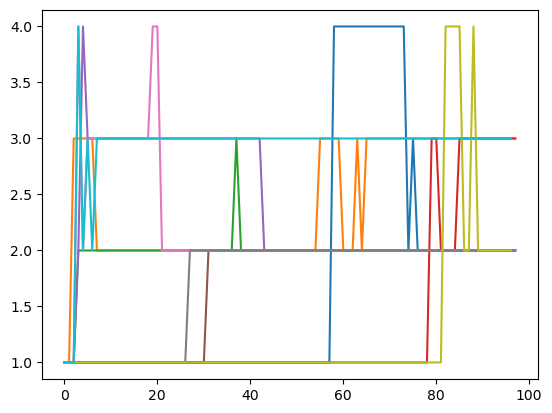

In [89]:
plt.plot(data.status[-10:,:].T.values)

In [7]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation


In [8]:
%%capture

ds = xr.open_zarr(file_name)

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 9e4)
ax.set_ylim(0, 5e4)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [9]:
HTML(anim.to_jshtml())

KeyboardInterrupt: 

In [28]:
data.release_time[-1,:-24].values

array([81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.,
       81000., 81000., 81000., 81000., 81000., 81000., 81000., 81000.])

In [ ]:
limit_begin_end = int(timedelta(days=2).total_seconds()/(60*60))
print(limit_begin_end)

In [ ]:
data_analysis = data.isel(obs=slice(limit_begin_end, -limit_begin_end))
tt = []
for i in range(0,len(data_analysis.obs)):
    tt.append(np.min(data_analysis.time[0,0].values).astype('datetime64[s]').tolist() + i*timedelta(hours=1))
times = np.tile(tt, (len(data_analysis.trajectory), 1))
#
data_analysis['time'].values = times

In [91]:
def particles_concentration_map(lons, lats, mask=mask, num_lon=30, num_lat=40):
    # Define lon and lat lenght 
    longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon + 1)
    latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat + 1)
    #
    # Particle positions into bins
    lon_indices = np.digitize(lons, longitudes) - 1 
    lat_indices = np.digitize(lats, latitudes) - 1
    #
    amount = np.zeros((num_lon, num_lat))
    #
    valid_mask = (lon_indices >= 0) & (lon_indices < num_lon) & (lat_indices >= 0) & (lat_indices < num_lat)
    lon_indices, lat_indices = lon_indices[valid_mask], lat_indices[valid_mask]
    # Count particles 
    indices = np.ravel_multi_index((lon_indices, lat_indices), dims=(num_lon, num_lat))
    counts = np.bincount(indices, minlength=num_lon * num_lat).reshape((num_lon, num_lat))
    #
    amount[:counts.shape[0], :counts.shape[1]] = counts
    #
    return pd.DataFrame(amount)

In [92]:
concentration_B = particles_concentration_map(lons=data.where(data['status'] == 4)['lon'], lats=data.where(data['status'] == 4)['lat'])
concentration_MP = particles_concentration_map(lons=data.where(data['status'] == 3)['lon'], lats=data.where(data['status'] == 3)['lat'])
concentration_C = particles_concentration_map(lons=data.where(data['status'] == 2)['lon'], lats=data.where(data['status'] == 2)['lat'])
concentration_SP = particles_concentration_map(lons=data.where(data['status'] == 1)['lon'], lats=data.where(data['status'] == 1)['lat'])
total_concentration = particles_concentration_map(lons=data['lon'], lats=data['lat'])

In [93]:
data1 = data
#
colloidal = []
marine = []
bottom = []
sewage = []
total = []
#
for i in range(len(data1.obs)):
    len_1 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 1.))[0])
    len_2 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 2.))[0])
    len_3 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 3.))[0])
    len_4 = len(np.where(np.isfinite(data1.status[:, i]) & (data1.status[:, i] == 4.))[0])
    #
    len_T = np.count_nonzero(~np.isnan(data1.status[:, i]))
    #
    sewage.append(len_1)
    colloidal.append(len_2)
    marine.append(len_3)
    bottom.append(len_4)
    total.append(len_T)
#    
proportion_colloidal = np.array(colloidal)/np.array(total)
proportion_marine = np.array(marine)/np.array(total)
proportion_bottom = np.array(bottom)/np.array(total)
proportion_sewage = np.array(sewage)/np.array(total)

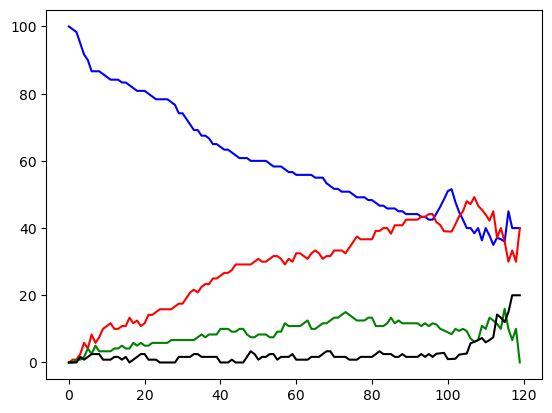

In [98]:
plt.plot(proportion_sewage*100, 'b')
plt.plot(proportion_colloidal*100, 'r')
plt.plot(proportion_marine*100, 'g')
plt.plot(proportion_bottom*100, 'k')

In [ ]:
plt.plot(data.h_vel, 'k')
#plt.axhline(y=5*10e-15, color = 'r')
plt.ylabel('Calculated Tau [Pa]')
plt.xlabel('Obs')
plt.hlines(y=0.017, xmin=0, xmax = data.obs[-1], colors = 'r')

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

$$\tau = u*^{2} \cdot \rho $$

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(data.u_vel.T, 'k')
ax[0,0].set_ylabel('U_vel')
ax[0,0].set_xlabel('Obs')
ax[0,1].plot(data.v_vel.T, 'k')
ax[0,1].set_ylabel('V_vel')
ax[0,1].set_xlabel('Obs')
ax[1,0].plot(data.h_vel.T, 'b')
ax[1,0].set_ylabel('H_vel')
ax[1,0].set_xlabel('Obs')
ax[1,1].plot(data.u_star.T, 'r')
ax[1,1].set_ylabel('U_star')
ax[1,1].set_xlabel('Obs')
#
plt.tight_layout()

In [ ]:
plt.plot(data.status.T)

NOTE: Super small values of Tau from the calculations inside the resuspension Kernel.
    
    - Reasons:
- U and V velocities, with the correction of bat_particle, they now decrease significantly (as they should). Therefore, since we are calculating the magnitude, which involves squares and square roots, this becomes even smaller. 

- Now, with the same correction for the variable e3t, the grid cell sizes are now bigger. Therefore, the ln() function increase and bigger values are in the denominator of u*


So, this correction now decreases and increases the numerator and denominator respectively, leading to a super small value of Tau

In [ ]:
clat = [49.195045]
clon = [-123.301956]
num_lon = 30
num_lat = 40
longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon+1)
latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat+1)

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#
fig, ax = plt.subplots(figsize=(8,8))
c = ax.pcolormesh(longitudes, latitudes, total_concentration.T, cmap='Reds', norm=LogNorm(vmin=total_concentration.min().min()+10e-1, vmax=total_concentration.max().max()))
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
#ax.set_xlim(0,tmask.x[-1])
#ax.set_ylim(0, tmask.y[-1])
#
ax.scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
#
fig.colorbar(c, ax=ax, label="Number of Particles (All Times)")
ax.legend()
#
ax.set_title('Concentration of Particles through 1 week simulation (2 days of hourly release)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#
fig, ax = plt.subplots(2,2,figsize=(12,12))
#
sewage = ax[0,0].pcolormesh(longitudes, latitudes, concentration_SP.T, cmap='Reds', norm=LogNorm(vmin=concentration_SP.min().min()+1, vmax=total_concentration.max().max()))
ax[0,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,0], label="Number of Particles (All Times)")
ax[0,0].legend()
ax[0,0].set_title('Concentration of Sewage Particles')
ax[0,0].set_ylabel('Latitude')
ax[0,0].set_xlabel('Longitude')
#
colloids = ax[0,1].pcolormesh(longitudes, latitudes, concentration_C.T, cmap='Reds', norm=LogNorm(vmin=concentration_C.min().min()+1, vmax=total_concentration.max().max()))
ax[0,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[0,1], label="Number of Particles (All Times)")
ax[0,1].legend()
ax[0,1].set_title('Concentration of Colloids')
ax[0,1].set_ylabel('Latitude')
ax[0,1].set_xlabel('Longitude')
#
marine = ax[1,0].pcolormesh(longitudes, latitudes, concentration_MP.T, cmap='Reds', norm=LogNorm(vmin=concentration_MP.min().min()+1, vmax=total_concentration.max().max()))
ax[1,0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(sewage, ax=ax[1,0], label="Number of Particles (All Times)")
ax[1,0].legend()
ax[1,0].set_title('Concentration of Marine Particles')
ax[1,0].set_ylabel('Latitude')
ax[1,0].set_xlabel('Longitude')
#
bottom = ax[1,1].pcolormesh(longitudes, latitudes, concentration_B.T, cmap='Reds', norm=LogNorm(vmin=concentration_B.min().min()+1, vmax=total_concentration.max().max()))
ax[1,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1,1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(bottom, ax=ax[1,1], label="Number of Particles (All Times)")
ax[1,1].legend()
ax[1,1].set_title('Concentration of Particles at Bottom')
ax[1,1].set_ylabel('Latitude')
ax[1,1].set_xlabel('Longitude')
